In [127]:
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, widgets
import numpy as np
from aicsimageio import AICSImage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.signal import butter, filtfilt
from tqdm import tqdm

In [2]:
# Open the .ims file
image = AICSImage('/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 8 um_2_2024-01-11_Confocal_00.43.45_DragonflyUser.ims')

# Get the image data as a numpy array
image_data = image.get_image_data("ZYX", S=0, T=0, C=0)

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


In [3]:
def show_image(i):
    plt.figure(dpi=100)
    plt.imshow(image_data[i], cmap='gray')
    plt.axis('off')
    plt.show()

slider = widgets.IntSlider(min=0, max=len(image_data)-1, step=1, value=0)
widgets.interact(show_image, i=slider)

interactive(children=(IntSlider(value=0, description='i', max=249), Output()), _dom_classes=('widget-interact'…

<function __main__.show_image(i)>

In [4]:
def subtractflatfield(input_img):
    grayscale_img = input_img
    poly2d_fcn = lambda xy, a, b, c, d, e, f: a + b*xy[0] + c*xy[1] + d*xy[0]*xy[0] + e*xy[1]*xy[1] + f*xy[0]*xy[1]

    y, x = np.indices(grayscale_img.shape)

    x_co = x.flatten()
    y_co = y.flatten()
    pix_val = grayscale_img.flatten()

    p0 = [1, 1, 1, 1, 1, 1]
    popt, _ = curve_fit(poly2d_fcn, (x_co, y_co), pix_val, p0=p0) 
    flat_field_img = poly2d_fcn((x_co, y_co), *popt).reshape(grayscale_img.shape)
    fit_img = grayscale_img - (flat_field_img)

    return fit_img

In [5]:
# for i in tqdm(range(len(image_data))):
#     image_data[i] = subtractflatfield(image_data[i])

In [6]:
frame_mean = []
frame_min = []
frame_max = []
frame_std = []
frame_95 = []
frame_05 = []
for i in range(len(image_data)):
    frame_mean.append(np.mean(image_data[i]))
    frame_min.append(np.min(image_data[i]))
    frame_max.append(np.max(image_data[i]))
    frame_std.append(np.std(image_data[i]))
    frame_95.append(np.percentile(image_data[i], 95))
    frame_05.append(np.percentile(image_data[i], 5))

plusband = []
minusband = []
for i in range(len(image_data)):
    plusband.append(frame_mean[i] + frame_std[i])
    minusband.append(frame_mean[i] - frame_std[i])

frame_mean_top = []
frame_mean_bottom = []
for i in range(len(image_data)//2):
    frame_mean_bottom.append(frame_mean[i])

for i in range(len(image_data)//2, len(image_data)):
    frame_mean_top.append(frame_mean[i])

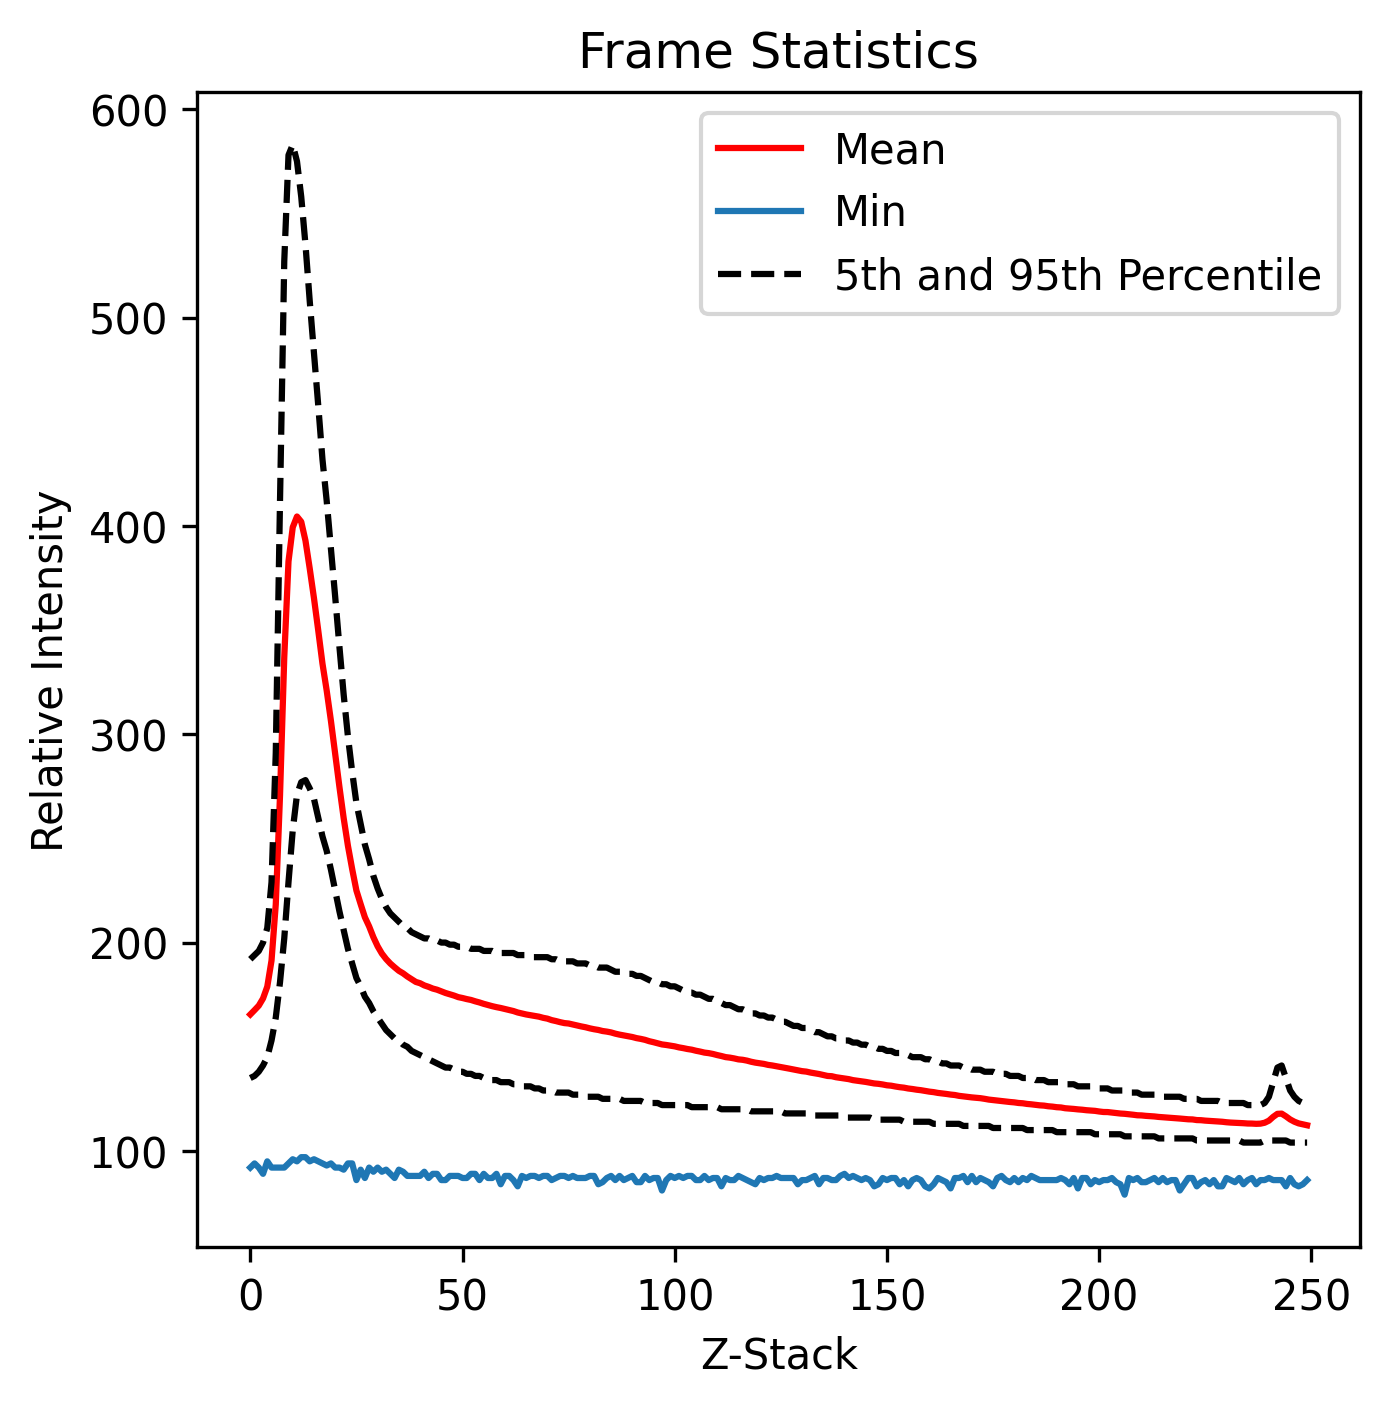

In [32]:
plt.figure(figsize=(5,5), dpi=300)
plt.plot(frame_mean, label='Mean', color='red')
plt.plot(frame_min, label='Min')
# plt.plot(frame_max, label='Max')
plt.plot(frame_95, label='5th and 95th Percentile', color='black', ls = '--')
plt.plot(frame_05, color='black', ls = '--')
# plt.plot(plusband, color='black', ls = (0, (2, 5)))
# plt.plot(minusband, color='black', ls = (0, (2, 5)))

plt.title('Frame Statistics')
plt.xlabel('Z-Stack')
plt.ylabel('Relative Intensity')

plt.legend()

plt.show()

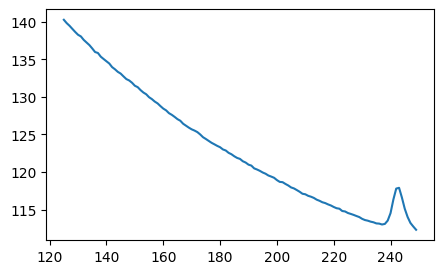

In [78]:
plt.figure(figsize=(5,3), dpi=100)
xhalf_length = len(image_data) // 2
xnew = np.arange(xhalf_length, len(image_data))
plt.plot(xnew, frame_mean_top)
plt.show()


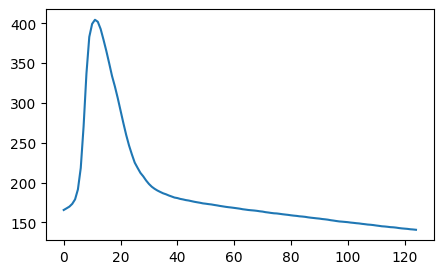

In [9]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(frame_mean_bottom)
plt.show()

In [10]:
def background_subtract(img_dat):
    x1 = np.min(img_dat)
    x2 = []
    for i in range(len(img_dat)):
        x2.append(img_dat[i] - x1)

    x2 = np.maximum(x2, 0)

    return x2

background_collect = background_subtract(frame_mean)

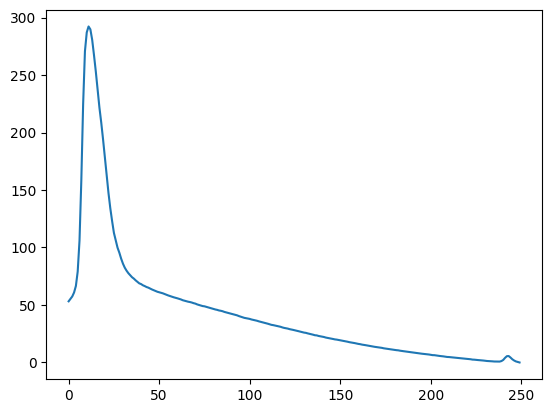

In [60]:
plt.plot(background_collect)

In [11]:
# def least_squares_background_reduction(signal, degree=1):
    
#     x = np.arange(len(signal))
#     A = np.vander(x, degree+1)
#     coeffs, _, _, _ = np.linalg.lstsq(A, signal, rcond=None)
#     background = np.dot(A, coeffs)
#     corrected_signal = signal - background
#     corrected_signal = np.maximum(corrected_signal, 0)

#     return corrected_signal

# corrected_collect = least_squares_background_reduction(np.array(frame_mean))

In [162]:
# # Create a high-pass filter
# b, a = butter(1, 0.01, btype='high')
# corrected_collect2 = filtfilt(b, a, frame_mean)
# corrected_collect2 = np.maximum(corrected_collect2, 0)
# plt.plot(corrected_collect2)

In [144]:
# # High pass filter peak detection

# peaks, _ = find_peaks(corrected_collect2, height = 1)
# print(peaks)
# print(corrected_collect2[peaks])
# botc = np.mean(corrected_collect2[(peaks[0]-5):(peaks[0]+5)])
# midc = np.mean(corrected_collect2[(peaks[0]+5):(peaks[1]-5)])
# topc = np.mean(corrected_collect2[(peaks[1]-5):(peaks[1]+5)])


[ 11 243]
[209.2611111    7.74813767]


In [145]:
# print(botc, midc, topc) 

161.33356497901661 4.306439591652125 4.961685554587509


In [146]:
# # High pass filter transmigration ratio
# (botc+midc)/(botc+midc+topc)*100

97.09165509969765

In [155]:
# Raw with baseline subtraction background reduction
peaks2, _ = find_peaks(background_collect, height = 1)
print(peaks2)
print(background_collect[peaks2])
b_size = 3
botc2= np.mean(background_collect[(peaks2[0]-b_size):(peaks2[0]+b_size)])
midc2 = np.mean(background_collect[(peaks2[0]+b_size+1):(peaks2[1]-b_size-1)])
topc2 = np.mean(background_collect[(peaks2[1]-b_size):(peaks2[1]+b_size)])
print(botc2, midc2, topc2)

[ 11 243]
[292.21282602   5.59090459]
274.12426981292515 37.510189228771864 4.073104676870744


In [156]:
# Raw with baseline subtraction background reduction
(botc2+midc2)/(botc2+midc2+topc2)*100

98.70984887758291

In [157]:
# # Break middle section into multiple means via chunks. Lower number means more chunks

# chunk_div = 10
# midtot = background_collect[(peaks2[0]+6):(peaks2[1]-6)]
# num_chunks = len(midtot) // chunk_div
# midtot_chunks = midtot[:num_chunks * chunk_div].reshape(-1, chunk_div)
# mean_chunks = midtot_chunks.mean(axis=1)

# print(mean_chunks)

In [158]:
# Percent transmigrated
(botc2+midc2)/(botc2+midc2+topc2)*100

98.70984887758291

In [159]:
# Percent on bottom channel region
botc2/(botc2+midc2+topc2)*100

86.82854049619434

In [160]:
# Percent on top channel region
topc2/(botc2+midc2+topc2)*100

1.2901511224170876

In [161]:
# Percent in middle/floating
midc2/(botc2+midc2+topc2)*100

11.881308381388573